#### Импорт библиотек

In [35]:
import pandas as pd 
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import seaborn as sns
import warnings


warnings.filterwarnings("ignore")

sns.set(style='whitegrid',
        rc={'figure.figsize': (20, 7)},
        font_scale=2)

#### Первый эксперимент

В этом опыте тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные (группа А -16:9, группа С - 12:4), либо новые квадратные (группа В). Нужно выяснить какой формат использовать в итоге.

#### Считывание и исследование данных

In [36]:
pict_format_test = pd.read_csv('5_task_1.csv')

In [37]:
pict_format_test.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [38]:
pict_format_test.shape

(30000, 3)

In [39]:
pict_format_test.group.value_counts()

A    10000
C    10000
B    10000
Name: group, dtype: int64

In [40]:
pict_format_test.dtypes

id         int64
group     object
events     int64
dtype: object

In [41]:
pict_format_test.isna().sum()

id        0
group     0
events    0
dtype: int64

In [42]:
pict_format_test.duplicated().sum()

0

#### Посмотрим, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего

In [43]:
pict_format_test \
    .groupby('group', as_index=False) \
    .agg({'events': 'mean'})

,group,events
0,A,29.5796
1,B,37.6136
2,C,27.4703


#### Так как у нас три группы, то я буду использовать однофакторный дисперсионный анализ ANOVA

Посмотрим, являются ли дисперсии внутри наших групп гомогенными, что является одним из необходимых требований перед использованием ANOVA

In [44]:
stats.levene(pict_format_test.query('group == "A"').events,
               pict_format_test.query('group == "B"').events,
               pict_format_test.query('group == "C"').events)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

#### P-value > 0.05, значит нулевую гипотезу о гомогенности дисперсий мы отклонить не можем

Я уже упомянул, что ANOVA требует гомогенность дисперсий. А вторым требованием является нормальность распределения данных (особенно на маленьких выборках). Проверим гипотезу об этом, применив тест Шапиро-Уилка.

In [45]:
sample = pict_format_test.query('group == "A"').events.sample(1000, random_state=17)
stats.shapiro(sample)

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [46]:
sample = pict_format_test.query('group == "B"').events.sample(1000, random_state=17)
stats.shapiro(sample)

ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)

In [47]:
sample = pict_format_test.query('group == "C"').events.sample(1000, random_state=17)
stats.shapiro(sample)

ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)

#### Заметим, что относительно всех трех групп p-value > 0.05, что не позволяет нам отклонить нулевую гипотезу о нормальном распределении данных в этих группах.

#### Проводим тест

In [48]:
stats.f_oneway(pict_format_test.query('group == "A"').events,
               pict_format_test.query('group == "B"').events,
               pict_format_test.query('group == "C"').events)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

#### Опираясь на результаты теста, мы можем сказать, что между тремя группами есть статистически значимые различия. Однако однофакторный дисперсионный анализ не дает информации о том, между какими конкретно группами мы нашли эти самые различия в выборочных средних. Для этого есть критерий Тьюки, который позволит нам узнать эти группы.

In [49]:
print(pairwise_tukeyhsd(pict_format_test.events, pict_format_test.group))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


#### Критерий Тьюки показал, что значимые различия есть между группами:
    
    А и В
    В и С
    А и С
    
    А также то, что в группе В наибольшее выборочное среднее, соотвественно, будем использовать В-квардратные картинки.

#### Второй эксперимент

Была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый. Требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

In [50]:
butt_format_test = pd.read_csv('5_task_2.csv')

In [51]:
butt_format_test.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [52]:
butt_format_test.shape

(100000, 4)

In [53]:
butt_format_test.dtypes

id           int64
group       object
segment     object
events     float64
dtype: object

In [54]:
butt_format_test.isna().sum()

id         0
group      0
segment    0
events     0
dtype: int64

In [55]:
butt_format_test.duplicated().sum()

0

In [56]:
butt_format_test.group.value_counts()

test       50000
control    50000
Name: group, dtype: int64

In [57]:
butt_format_test.segment.value_counts()

low     80000
high    20000
Name: segment, dtype: int64

#### Посмотрим на распределение events для контрольной и тестовой групп

Контрольная

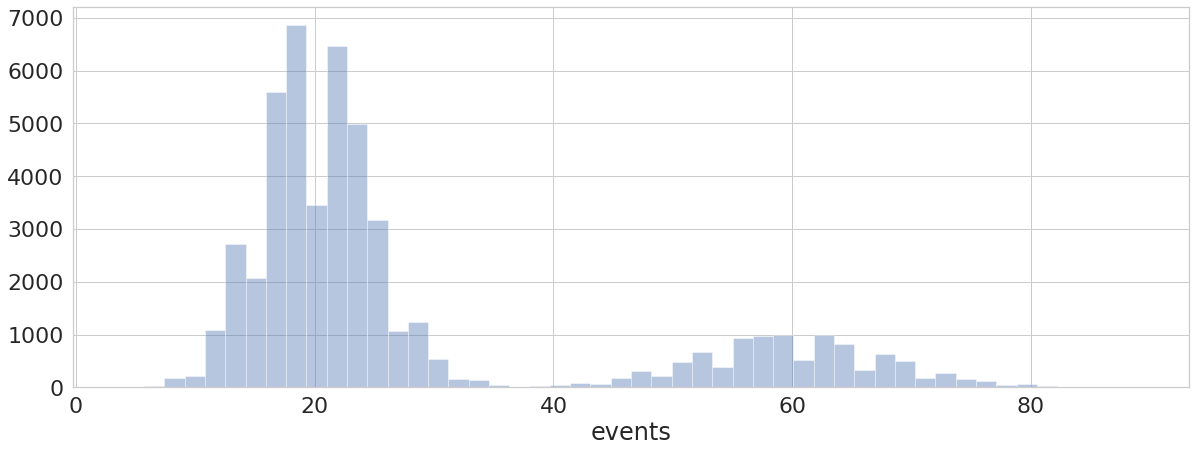

In [61]:
control_group = butt_format_test.query('group == "control"').events
sns.distplot(control_group, kde=False);

Тестовая

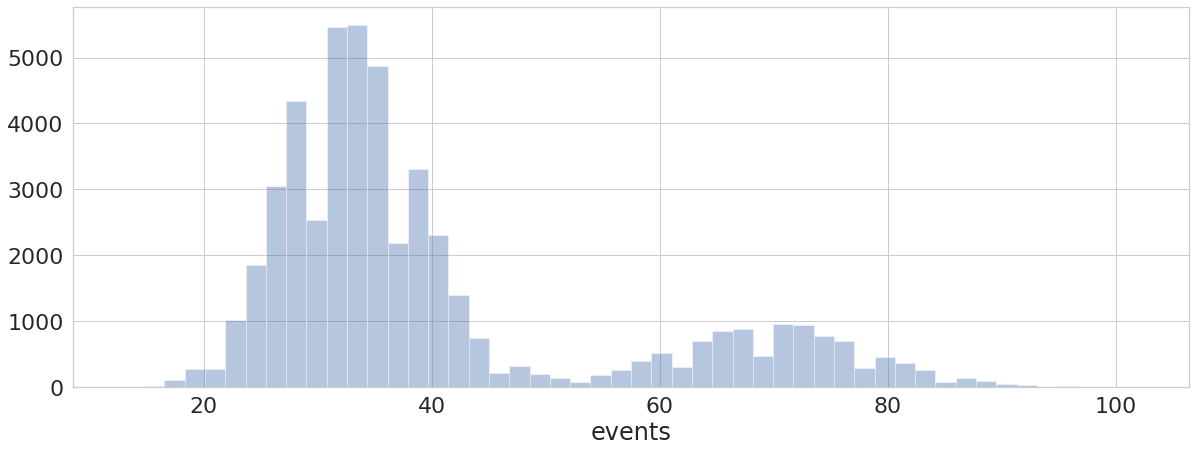

In [62]:
test_group = butt_format_test.query('group == "test"').events
sns.distplot(test_group, kde=False);

#### Посчитаем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

In [60]:
butt_format_test \
    .groupby(['group', 'segment'], as_index=False) \
    .agg({'events': 'describe'})

group segment   events                                               \
                      count       mean       std   min   25%   50%   75%   
0  control    high  10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   
1  control     low  40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   
2     test    high  10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0   
3     test     low  40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   

          
     max  
0   89.0  
1   41.0  
2  102.0  
3   59.0

#### В первом эсперименте я использовал однофакторный ANOVA, однако в данной ситуации я не могу себе это позволить, так как у нас теперь две номинативные переменные. Для этого есть другой критерий: многофакторный ANOVA.

Сформируем формулу для модели: слева зависимая переменная, справа - независимые (не забывая про взаимодействие факторов).

In [75]:
formula = 'butt_format_test.events ~ butt_format_test.group + butt_format_test.segment + butt_format_test.group:butt_format_test.segment'

In [76]:
model = ols(formula, butt_format_test.events).fit()
aov_table = anova_lm(model, typ=2)

In [77]:
aov_table

,sum_sq,df,F,PR(>F)
butt_format_test.group,3.837195e+06,1.0,112031.864119,0.000000e+00
butt_format_test.segment,2.362480e+07,1.0,689756.377484,0.000000e+00
butt_format_test.group:butt_format_test.segment,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


#### Значимые различия есть. Выясним, в каких группах конкретно.

В данном случае для последующих сравнений между группами можно проделать следующую операцию: соединим колонки group и segment в combination, чтобы потом передать в аргумент groups в MultiComparison

In [78]:
butt_format_test['combination'] = butt_format_test['group'] + ' / ' + butt_format_test['segment']

In [79]:
butt_format_test['combination']

0          test / high
1          test / high
2          test / high
3          test / high
4          test / high
             ...      
99995    control / low
99996    control / low
99997    control / low
99998    control / low
99999    control / low
Name: combination, Length: 100000, dtype: object

#### Теперь снова используем критерий Тьюки

In [80]:
print(pairwise_tukeyhsd(butt_format_test.events, butt_format_test.combination))

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2    meandiff p-adj  lower    upper   reject
--------------------------------------------------------------------
control / high control / low -39.9392 0.001 -40.1073 -39.7711   True
control / high   test / high   9.9677 0.001   9.7551  10.1803   True
control / high    test / low -26.9449 0.001  -27.113 -26.7768   True
 control / low   test / high  49.9069 0.001  49.7388   50.075   True
 control / low    test / low  12.9944 0.001   12.888  13.1007   True
   test / high    test / low -36.9126 0.001 -37.0807 -36.7445   True
--------------------------------------------------------------------


#### Видно следующее:

    -Для обоих сегментов показатели статистически значимо увеличились по сравнению с контрольной группой
    -Разница между значением у тестовой группы и контрольной группой сегмента low равна примерно 13
    -Разница между control/high и test/high составила около 10

#### Визуализируем результаты теста

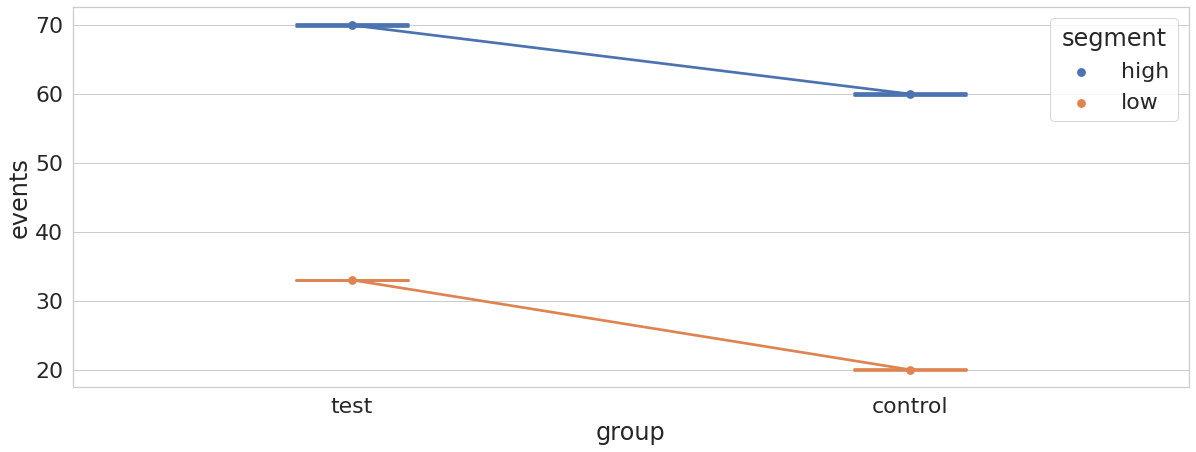

In [83]:
sns.pointplot(x = 'group', y = 'events', hue='segment', data = butt_format_test, capsize = .2);

#### По графику видно, что:

    факторы group и segment и их взаимодействие оказались значимыми, среднее значение events для всех групп увеличилось, поэтому выкатываем новую версию.